# SEIRD Model Optimisation

In this notebook we present how to use the `epimodels` module to perform parameter optimisation for the  parameters specified by the SEIRD model.

The analysis is run for:
 - Dates: **15 Feb 2020** - **25 June 2020**;
 - PHE regions of interest: **London**.

We use realistic serology and mortality data extracted from the REACT survey and GOV.UK data.


In [1]:
# Load necessary libraries
import os
import numpy as np
import pandas as pd
from scipy.stats import gamma, nbinom, norm
import epimodels as em
import matplotlib
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
from iteration_utilities import deepflatten

# Set random seed
np.random.seed(28)

## Model Setup
### Define setup matrices for the SEIRD model

In [2]:
# Populate the model
total_days =  132
regions = ['London']
age_groups = ['0-1', '1-5', '5-15', '15-25', '25-45', '45-65', '65-75', '75+']

### Set the parameters and initial conditions of the model and bundle everything together

In [3]:
# Instantiate model
model = em.SEIRDModel()

# Set the region names of the model
model.set_regions(regions)

# Initial number of susceptibles
path = os.path.join('../../data/england_population/England_population.csv')
total_susceptibles = np.loadtxt(path, dtype=int, delimiter=',').tolist()
susceptibles = np.sum(total_susceptibles[1])

# Initial number of infectives
infectives = [9]

# List of times at which we wish to evaluate the states of the compartments of the model
times = np.arange(1, total_days+1, 1).tolist()

# Probability of death
Pd = np.sum(np.multiply(total_susceptibles[1], pd.read_csv('../../data/fatality_ratio_data/CFR.csv', usecols=['cfr'], dtype=np.float64)['cfr'].values)) / susceptibles

In [4]:
# Set ICs parameters
ICs = em.SEIRDICs(
    model=model,
    susceptibles_IC=[susceptibles],
    exposed_IC=np.zeros(len(regions)).tolist(),
    infectives_IC=infectives,
    recovered_IC=np.zeros(len(regions)).tolist(),
    dead_IC=np.zeros(len(regions)).tolist()
)

# Set transmission parameters
transmission_parameters = em.SEIRDTransmission(
    model=model,
    beta=5,
    kappa=6,
    gamma=7.7,
    Pd = Pd
)

# Set other simulation parameters
simulation_parameters = em.SEIRDSimParameters(
    model=model,
    region_index=1,
    method='RK45',
    times=times
)

# Set all parameters in the controller
parameters = em.SEIRDParametersController(
    model=model,
    ICs=ICs,
    transmission_parameters=transmission_parameters,
    simulation_parameters=simulation_parameters
)

### Simulate for one of the regions: **London**

In [5]:
# Simulate for all regions
output = []
new_infec = []
new_deaths = []

for r, reg in enumerate(regions):
    # List of initial conditions and parameters that characterise the model
    parameters.simulation_parameters.region_index = r + 1

    # Simulate using the ODE solver
    output.append(model.simulate(parameters))
    new_infec.append(model.new_infections(output[-1]))
    new_deaths.append(model.new_deaths(output[-1]))

## Death and Serology data
### Read Tests data

In [6]:
# # Read in tests data from external files for realistic counts of tests
# tests = []

# for region in regions:
#     daily_tests = np.ones((len(times), len(age_groups)), dtype=int)
#     weekly_tests = np.loadtxt('../../data/serology_data/{}_tests_nhs.csv'.format(region), dtype=int, delimiter=',')
#     for _, day in enumerate(np.arange(0, len(times), 7)):
#         daily_tests[day:(day+7), :]=weekly_tests[_, :] / 7
#     tests.append(daily_tests)

## Read Death and Serology data

In [7]:
# Read in death and positive data from external files
deaths_data = []
positives_data = []
tests = []

for region in regions:
    deaths_data.append(np.sum(np.loadtxt('../../data/death_data/{}_deaths.csv'.format(region), dtype=int, delimiter=','), axis=1))
    positives_data.append(np.sum(np.loadtxt('../../data/serology_data/{}_positives_nhs.csv'.format(region), dtype=int, delimiter=','), axis=1))
    tests.append(np.sum(np.loadtxt('../../data/serology_data/{}_tests_nhs.csv'.format(region), dtype=int, delimiter=','), axis=1))

In [8]:
# Select the time points for which the death and serology data is known
deaths_times = np.arange(27, total_days+1, 1).tolist()
serology_times = np.arange(80, total_days+1, 7).tolist()

In [9]:
# Set information
niu = 10**(-5) # float(gamma.rvs(1, scale=1/0.2, size=1))

sens = 0.7
spec = 0.95

### Sample Death and Serology data

In [10]:
# # Sample death and positive test results data for all regions
# deaths_data = []
# positives_data = []

# for r, reg in enumerate(regions):
#     reg_deaths_data = np.empty((len(times), len(age_groups)))
#     reg_positives_data = np.empty(((len(times), len(age_groups))))
#     for t, _ in enumerate(times):
#         # Sample the number of deaths and positive test results in a given region on a given day
#         reg_deaths_data[t, :] = model.samples_deaths(new_deaths[r], niu, t)
#         reg_positives_data[t, :] = model.samples_positive_tests(output[r], tests[r][t, :], sens, spec, t)
#     deaths_data.append(np.asarray(reg_deaths_data, dtype=int))
#     positives_data.append(np.asarray(reg_positives_data, dtype=int))

### Export Death and Serology data

In [11]:
# # Export synthetic death and positive test results data for all regions to external files to save computation time
# path_ = 'inference_data/'

# for r, region in enumerate(regions):
#     path = os.path.join(path_, '{}_Syn_Deaths.csv'.format(region))
#     path1 = os.path.join(path_, '{}_Syn_Positives.csv'.format(region))

#     np.savetxt(path, deaths_data[r], fmt="%d", delimiter=',')
#     np.savetxt(path1, positives_data[r], fmt="%d",  delimiter=',')

### Read Death and Serology data

In [12]:
# # Read in synthetic death and positive data from external files
# deaths_data = []
# positives_data = []

# for region in regions:
#     deaths_data.append(np.loadtxt('inference_data/{}_Syn_Deaths.csv'.format(region), dtype=int, delimiter=','))
#     positives_data.append(np.loadtxt('inference_data/{}_Syn_Positives.csv'.format(region), dtype=int, delimiter=','))

In [13]:
# # Select the time points for which the death and serology data is known
# deaths_times = np.arange(1, total_days+1, 1).tolist()
# serology_times = np.arange(1, total_days+1, 1).tolist()

## Optimisation Procedure

In [14]:
# Initialise optimisation for the model
seird_optimisation = em.inference.SEIRDInfer(model, Pd)

# Add model, death, tests and NPIs data to the inference structure
seird_optimisation.read_model_data(susceptibles, infectives)
seird_optimisation.read_deaths_data(deaths_data, deaths_times)
seird_optimisation.read_serology_data(tests, positives_data, serology_times, sens, spec)

# Run optimisation structure
found, log_post_value = seird_optimisation.optimisation_problem_setup(times, wd=1, wp=0)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time m:s
0     6     -46672.4  -46672.4    0:00.3
1     12    -46672.4  -59050.19   0:00.6
2     18    -5467.596 -5467.596   0:00.9
3     24    -5467.596 -17176.08   0:01.2
20    126   -1967.887 -1967.887   0:06.7
40    246   -739.5448 -739.5448   0:15.0
60    366   -657.2288 -669.6094   0:25.0
80    486   -656.092  -656.1055   0:36.4
100   606   -656.0888 -656.0888   0:47.9
120   726   -656.0888 -656.0888   0:59.5
140   846   -656.0888 -656.0888   1:10.9
160   966   -656.0888 -656.0888   1:22.4
174   1044  -656.0888 -656.0888   1:29.9
Halting: No significant change for 100 iterations.
[ 7.8809427  18.64075548] -656.0887585442089
Optimisation phase is finished.


### Run the model with optimised parameter choices to produce predicted timelines for the:
 - number of new infections
 - number of deaths
 - R number

In [15]:
n_parameters = model.n_parameters()

predicted_new_infec = []
predicted_deaths = []
#predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(model.regions):
    parameters.simulation_parameters.region_index = r + 1

    parameters.transmission_parameters.beta = found[0]
    parameters.transmission_parameters.kappa = found[1]
    # parameters.transmission_parameters.gamma = found[1]
    
    #r_fix = np.empty(len(times))
    model_reg_deaths_data = np.empty(len(times))

    #m_fix = em.MultiTimesInfectivity(
    #    matrices_contact, time_changes_contact, regions, matrices_region, time_changes_region, parameters[0], dI, susceptibles)

    # Run model and number of new infections for all age groups
    model_output = model.simulate(parameters)

    model_reg_new_infections = model.new_infections(model_output)

    age_model_reg_new_deaths = model.new_deaths(model_output)

    for t, time in enumerate(times):
    #    r_fix[t] = m_fix.compute_reproduction_number(r+1, time, model_output[t, :len(age_groups)], temp_variation=parameters[8][r][t])
        model_reg_deaths_data[t] = np.sum(model.mean_deaths(t, age_model_reg_new_deaths))
    
    predicted_new_infec.append(np.array(model_reg_new_infections))
    predicted_deaths.append(model_reg_deaths_data)
    #predicted_reprod_num.append(r_fix)

predicted_new_infec = np.array(predicted_new_infec)
predicted_deaths = np.array(predicted_deaths)
#predicted_reprod_num = np.array(predicted_reprod_num)

## Plot data vs predicted

### Setup ``plotly`` and default settings for plotting

In [16]:
from plotly.subplots import make_subplots

colours = ['blue', 'red', 'green', 'purple', 'orange', 'black', 'gray', 'pink']

# Group outputs together
outputs = [deaths_data, positives_data]

# Number of regions
n_reg = len(regions)

### Select predicted quantities to plot

In [17]:
# Set up traces to plot
new_infec_pred = []
deaths_pred = []
#reprod_num_pred = []

for r, _ in enumerate(model.regions):
    # Compute the prediction 
    new_infec_pred.append(predicted_new_infec[r,:])
    deaths_pred.append(predicted_deaths[r,:])
    #reprod_num_pred.append(predicted_reprod_num[r,:])

### Plot observed versus predicted using model with optimised parameters

In [18]:
# Trace names - represent the solver used for the simulation
trace_name = regions
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (continuous predicted timeline and pointwise observed numbers each day)
for r, region in enumerate(regions):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=new_infec_pred[r].tolist(),
            mode='lines',
            name=trace_name[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=serology_times,
            y=(susceptibles * np.nan_to_num(np.divide(positives_data[r], tests[r]))).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=deaths_pred[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=deaths_times,
            y=deaths_data[r],
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    #fig.add_trace(
    #    go.Scatter(
    #        x=times,
    #        y=reprod_num_pred[r].tolist(),
    #        mode='lines',
    #        name=trace_name[r],
    #        showlegend=False,
    #        line_color=colours[r]
    #    ),
    #    row= 3,
    #    col= 1
    #)

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-3-optimisation.pdf')
fig.show()

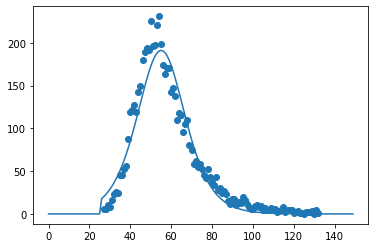

In [19]:
plt.plot(model.actual_deaths)
plt.scatter(deaths_times, deaths_data[r].tolist()[:len(deaths_times)])

In [20]:
p_after = parameters()

In [21]:
seird_optimisation.ll(found)
p = seird_optimisation.ll._parameters
p_found = list(deepflatten(p, ignore=str))

In [22]:
for p1, p2 in zip(p_after, p_found):
    print(p1, p2)

1 1
8961989 8961989
0.0 0.0
9 9
0.0 0.0
0.0 0.0
7.880942700030988 7.880942700030988
18.640755476424044 18.640755476424044
7.7 7.7
0.014688600811047638 0.014688600811047638
RK45 RK45


In [23]:
import matplotlib
from matplotlib import pyplot as plt

In [24]:
loglik_arr = np.empty((25,25))

for ind_beta, beta in enumerate(np.linspace(0.1, 20, 25)):
    for ind_kappa, kappa in enumerate(np.linspace(0.01, 20, 25)):
        loglik_arr[ind_beta, ind_kappa] = seird_optimisation.return_loglikelihood(times, [beta, kappa])

plt.imshow(loglik_arr, cmap='viridis', extent=[0.1,20,20,0.01])

print(np.max(loglik_arr))
i,j = np.unravel_index(loglik_arr.argmax(), loglik_arr.shape)
print(np.linspace(0.1, 20, 25)[i], np.linspace(0.01, 20, 25)[j])
print(np.max(loglik_arr) == loglik_arr[i, j])
print(seird_optimisation.return_loglikelihood(times, [np.linspace(0.1, 20, 25)[i], np.linspace(0.01, 20, 25)[j]]) == loglik_arr[i, j])

plt.colorbar()
plt.xlabel('beta')
plt.ylabel('kappa')
plt.show()

In [ ]:
seird_optimisation.return_loglikelihood(times, [6.7333333333333325, 1.6758333333333333])

-52926.08665463418

In [ ]:
seird_optimisation.return_loglikelihood(times, [6.159066054213871, 19.99999999842747])

-74180.814841958